In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import spacy
import pyarabic.araby as araby

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [4]:
txt = open("ar_cations.txt", "r")

In [5]:
lines = txt.readlines()

In [6]:
lines[555].split('\t')

['1508269285_6c5723f67d.jpg#0', 'الكلب يقف في الماء بجانب العشب\n']

In [7]:
image = lines[555].split('\t')[0].split("#")[0]; image

'1508269285_6c5723f67d.jpg'

In [8]:
line = lines[0].split('\t')[1].strip(); line

'طفلة صغيرة تتسلق إلى مسرح خشبي'

In [9]:
araby.tokenize(line)

['طفلة', 'صغيرة', 'تتسلق', 'إلى', 'مسرح', 'خشبي']

In [10]:
images, captions = [], []
for line in lines:
    images.append(line.split('\t')[0].split("#")[0])
    captions.append(line.split('\t')[1].strip())

In [11]:
images[:4], captions[:4]

(['1000268201_693b08cb0e.jpg',
  '1001773457_577c3a7d70.jpg',
  '1002674143_1b742ab4b8.jpg',
  '1003163366_44323f5815.jpg'],
 ['طفلة صغيرة تتسلق إلى مسرح خشبي',
  'كلب أسود وكلب ثلاثي الألوان يلعبان مع بعضهما البعض على الطريق',
  'فتاة صغيرة مغطاة بالطلاء تجلس أمام قوس قزح',
  'رجل يجلس على مقعد بينما يجلس كلبه بجانبه'])

In [12]:
class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.freq_threshold = freq_threshold
        self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
        self.stoi = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
        
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenize_en(text):
        return [tok.lower() for tok in araby.tokenize(text)]
    
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize_en(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    def numericalize(self, text):
        tokenizd_text = self.tokenize_en(text)
        
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] 
                for token in tokenizd_text]

In [13]:
vocab = Vocabulary()
vocab.build_vocabulary(captions)

In [14]:
[vocab.itos[i] for i in vocab.numericalize(captions[1])]

['كلب',
 'أسود',
 'وكلب',
 'ثلاثي',
 'الألوان',
 'يلعبان',
 'مع',
 'بعضهما',
 'البعض',
 'على',
 'الطريق']

In [15]:
captions[1]

'كلب أسود وكلب ثلاثي الألوان يلعبان مع بعضهما البعض على الطريق'

In [21]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, transform=None, freq_threshold=2):
        self.root_dir = root_dir
        self.transform = transform
        
        self.imgs = images
        self.captions = captions
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions)
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(self.root_dir+img_id).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [22]:
ds = FlickrDataset("Images/")

'<SOS> رجل يجلس على مقعد بينما يجلس كلبه بجانبه <EOS>'

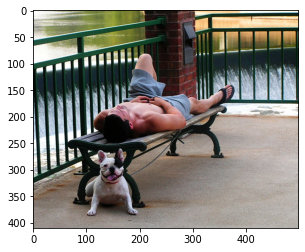

In [36]:
x = 3
plt.imshow(ds[x][0]);
' '.join([ds.vocab.itos[i.item()] for i in ds[x][1]])

In [37]:
pad_idx = ds.vocab.stoi["<PAD>"]

In [38]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
        
    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=pad_idx)
        
#         print(imgs.shape)
#         print(targets.shape)
        return imgs, targets

In [39]:
class EncoderCNN(nn.Module):
    def __init__(self, hid_dim, dropout, train_cnn=False):
        super().__init__()
        
        self.hid_dim = hid_dim        
        self.train_cnn = train_cnn
        
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, hid_dim)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, images):
        features = self.dropout(self.relu(self.inception(images)))
        return features

In [40]:
class DecoderRNN(nn.Module):
    def __init__(self, emb_dim, hid_dim, vocab_sz, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.vocab_sz = vocab_sz
        
        self.embedding = nn.Embedding(vocab_sz, emb_dim)
        
        # GRU: inputs-> [embeddings + context], output -> hidden, output
        self.rnn = nn.GRU(emb_dim+hid_dim, hid_dim)
        
        # FC: inputs:-> [embeddings + context + output]
        self.fc_out = nn.Linear(emb_dim + hid_dim*2, vocab_sz)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, context):
        #input = [batch size]
        #hidden = [1, batch size, hid dim]
        #context = [1, batch size, hid dim]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
#         print(f'Context shape {context.shape}')
#         print(f'embeded shape {embedded.shape}')
        
        emb_con = torch.cat((embedded, context), dim=2)
        #emb_con = [1, batch size, emb_dim + hid_dim]
        
#         print(f"Hidden shape {hidden.shape}")
#         print(f"embedded shape {embedded.shape}")
#         print(f"context shape {context.shape}")
#         print(f"emb_con shape {emb_con.shape}")
#         print('_'*22)
        
        output, hidden = self.rnn(emb_con, hidden)
        #output = [1, batch size, hid dim] -> seq len and n directions = 1
        #hidden = [1, batch size, hid dim] -> n layers and n directions =1
        
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), dim=1)
        #output = [batch size, emb_dim + hid_dim*2]
        
        predictions = self.fc_out(output)
        #predictions = [batch size, vocab size]
        
        return predictions, hidden

In [151]:
###
### No teacher forcing for now
###
class Img2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert self.encoder.hid_dim == self.decoder.hid_dim,\
            'The hid dim of the context vector must equal the hid dim of the decoder !!'
            
    def forward(self, img, trg):
        #src = [batch size, 3, 224, 224]
        #trg = [trg len, batch size]
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.vocab_sz
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        context = self.encoder(img)
        context = context.unsqueeze(0)
        hidden = context
        
        input = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context)
            
            outputs[t] = output
            
            top1 = output.argmax(1)
            
            input = top1
            
        return outputs
    
    def caption_image(self, img, max_length=50):
        result_caption = []

            
        
        with torch.no_grad():
            # context = [1, batch size, hid dim]
            context = self.encoder(img).unsqueeze(0)
            hidden = context
            input = torch.tensor(1).unsqueeze(0).to(device)
            
            for t in range(1, max_length):
                output, hidden = self.decoder(input, hidden, context)
                top1 = output.argmax(1)
                input = top1
                result_caption.append(top1.item())
                if vocab.itos[top1.item()] == '<EOS>':
                    break
        return [vocab.itos[idx] for idx in result_caption]

In [152]:
HID_DIM = 256
EMB_DIM = 256
DROPOUT = .5
VOCAB_LENGTH = len(ds)
TRAIN_CNN = False
bs = 265
lr = 3e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

enc = EncoderCNN(HID_DIM, DROPOUT)
dec = DecoderRNN(EMB_DIM, HID_DIM, VOCAB_LENGTH, DROPOUT)

model = Img2Seq(enc, dec, device).to(device)

In [153]:
criterion = nn.CrossEntropyLoss(ignore_index=ds.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=lr)

# only finetune the CNN
for name, param in model.encoder.inception.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = TRAIN_CNN

In [154]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,317,379 trainable parameters


In [155]:
# transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [156]:
train_loader = DataLoader(
    dataset=FlickrDataset("Images/", transform),
    batch_size=bs,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
    collate_fn=MyCollate(pad_idx=pad_idx),
    drop_last=True
)

In [157]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for idx, (imgs, captions) in tqdm(
        enumerate(iterator), total=len(iterator), leave=False
    ):
        
        optimizer.zero_grad()
        
        imgs = imgs.to(model.device)
        captions = captions.to(model.device)
        
        output = model(imgs, captions)
        
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        #flattening the output and target + ignoring <sos>
        output = output[1:].view(-1, output_dim)
        trg = captions[1:].view(-1)
        
        #trg = [(trg len -1) * batch size]
        #output = [(trg len -1) * batch size, output dim]
        
        
        loss = criterion(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [158]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [159]:
import torch
from tqdm import tqdm,trange
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

In [ ]:
import math
N_EPOCHS = 20
CLIP = 1

best_train_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
#     valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(model.state_dict(), 'GRU-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 26s
	Train Loss: 4.305 | Train PPL:  74.063


Epoch: 02 | Time: 0m 26s
	Train Loss: 4.275 | Train PPL:  71.890


Epoch: 03 | Time: 0m 26s
	Train Loss: 4.256 | Train PPL:  70.539


Epoch: 04 | Time: 0m 26s
	Train Loss: 4.253 | Train PPL:  70.302


Epoch: 05 | Time: 0m 26s
	Train Loss: 4.232 | Train PPL:  68.844


Epoch: 06 | Time: 0m 26s
	Train Loss: 4.219 | Train PPL:  67.974


Epoch: 07 | Time: 0m 26s
	Train Loss: 4.193 | Train PPL:  66.204


Epoch: 08 | Time: 0m 26s
	Train Loss: 4.189 | Train PPL:  65.975


Epoch: 09 | Time: 0m 26s
	Train Loss: 4.163 | Train PPL:  64.250


Epoch: 10 | Time: 0m 26s
	Train Loss: 4.160 | Train PPL:  64.041


Epoch: 11 | Time: 0m 26s
	Train Loss: 4.155 | Train PPL:  63.734


Epoch: 12 | Time: 0m 26s
	Train Loss: 4.146 | Train PPL:  63.193


Epoch: 13 | Time: 0m 26s
	Train Loss: 4.131 | Train PPL:  62.224


 47%|████▋     | 7/15 [00:13<00:14,  1.85s/it]

In [163]:
def print_examples(model, device, csv_name, root_dir='test_examples'):
    model.eval()
    df = pd.read_csv(csv_name)
    imgs = df['image'].tolist()
    captions = df['description'].tolist()
    i = 1
    for img_id, cap in zip(imgs, captions):
        img = Image.open(root_dir+'/'+img_id).convert("RGB")
        plt.imshow(img)
        plt.title(f'Example {i} Correct: {cap}')
        plt.axis('off')
        img = transform(img).unsqueeze(0)
        print(f"Output: {' '.join(model.caption_image(img.to(device)))}")
        plt.show()
        i+=1

Output: كلب بني يركض في <EOS>


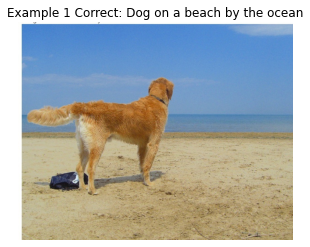

Output: صبي صغير في <UNK> <EOS>


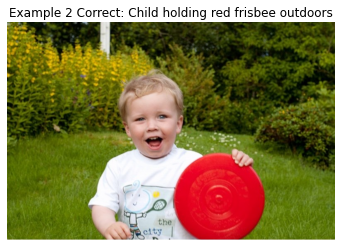

Output: رجل في <UNK> <UNK> <UNK> <EOS>


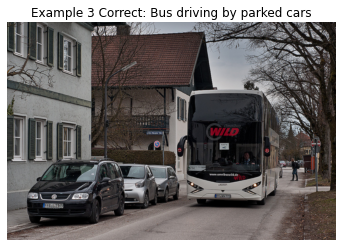

Output: رجل في على في <EOS>


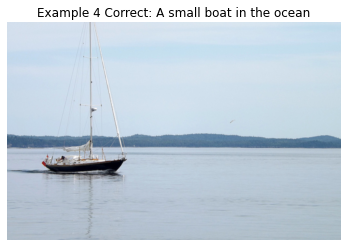

Output: رجل في على على <EOS>


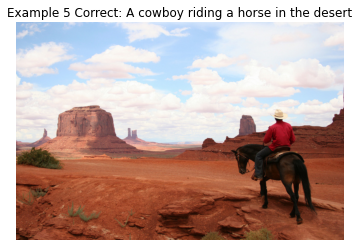

In [164]:
print_examples(model, device, 'test.csv')

In [35]:
torch.save(model.state_dict(), "models/first.pth")

In [57]:
model = Img2Seq(enc, dec, device).to(device)

In [58]:
model.load_state_dict(torch.load("models/first.pth"))

<All keys matched successfully>